In [1]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


cp: missing destination file operand after './drive/MyDrive/Colab Notebooks/data'
Try 'cp --help' for more information.


In [3]:
!cp './drive/MyDrive/Colab Notebooks/dataset/Peliculas.zip'  ./Peliculas.zip

In [4]:
!unzip ./Peliculas.zip 

Archive:  ./Peliculas.zip
replace Peliculas/fights/newfi1.avi? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
import time
import sys
import pandas as pd
import numpy as np
import cv2
import pickle
import skvideo.io
import h5py
from tables import *
from sklearn import metrics
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG19,ResNet50
from tensorflow.keras.layers import LSTM , Dense , TimeDistributed, Flatten, Dropout, GlobalAveragePooling2D, GlobalAveragePooling1D, Input
from tensorflow.keras.layers import Reshape, BatchNormalization ,ConvLSTM2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam , RMSprop, SGD

#Parameters
NUMBER_OF_FRAMES = 20
IMAGE_SIZE = 160
IMAGE_CHANNELS = 3

In [6]:
dtframe = pd.DataFrame()
vid = []
lab = []
for i in range(500):
  vid.append("fi"+ str(i+1) +"_xvid.avi")
  lab.append(1)
  vid.append("no"+ str(i+1) +"_xvid.avi")
  lab.append(0)
dtframe['video_name'] = vid
dtframe['tag'] = lab
dtframe.head

<bound method NDFrame.head of          video_name  tag
0      fi1_xvid.avi    1
1      no1_xvid.avi    0
2      fi2_xvid.avi    1
3      no2_xvid.avi    0
4      fi3_xvid.avi    1
..              ...  ...
995  no498_xvid.avi    0
996  fi499_xvid.avi    1
997  no499_xvid.avi    0
998  fi500_xvid.avi    1
999  no500_xvid.avi    0

[1000 rows x 2 columns]>

In [7]:
dtframe2 = pd.DataFrame()
vid2 = []
lab2 = []
for i in range(100):
  vid2.append("./Peliculas/fights/newv"+ str(i+1) +".mp4")
  lab2.append(1)
  vid2.append("./Peliculas/noFights/" + str(i+1) +".mpg")
  lab2.append(0)
dtframe2['video_name'] = vid2
dtframe2['tag'] = lab2
dtframe2.head

<bound method NDFrame.head of                          video_name  tag
0      ./Peliculas/fights/newv1.mp4    1
1        ./Peliculas/noFights/1.mpg    0
2      ./Peliculas/fights/newv2.mp4    1
3        ./Peliculas/noFights/2.mpg    0
4      ./Peliculas/fights/newv3.mp4    1
..                              ...  ...
195     ./Peliculas/noFights/98.mpg    0
196   ./Peliculas/fights/newv99.mp4    1
197     ./Peliculas/noFights/99.mpg    0
198  ./Peliculas/fights/newv100.mp4    1
199    ./Peliculas/noFights/100.mpg    0

[200 rows x 2 columns]>

In [8]:
traindf = dtframe[:100]
traindf = traindf.append(dtframe2[:150],ignore_index= True)
valdf = dtframe[101:151]
valdf = valdf.append(dtframe2[151:189], ignore_index= True)
traindf = traindf.sample(frac=1).reset_index(drop=True)
valdf = valdf.sample(frac=1).reset_index(drop=True)

In [9]:
def autocrop(image, threshold=0):
    if len(image.shape) == 3:
        flatImage = np.max(image, 2)
    else:
        flatImage = image
    assert len(flatImage.shape) == 2

    rows = np.where(np.max(flatImage, 0) > threshold)[0]
    if rows.size:
        cols = np.where(np.max(flatImage, 1) > threshold)[0]
        image = image[cols[0]: cols[-1] + 1, rows[0]: rows[-1] + 1]
    else:
        image = image[:1, :1]

    return image

In [10]:
def scale_and_resize(image):

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = autocrop(image)
  image = cv2.resize(image,(IMAGE_SIZE,IMAGE_SIZE))
  image = image/255.0
  
  return image.astype('float16')
  

In [11]:
def extract_frames(videodf, start_index = 0, end_index =-1):

  output_videos = []
  output_labels = []

  if end_index is -1:
    end_index = videodf.shape[0]
  for i in range(start_index, end_index):

    try:
      videodata = skvideo.io.vread(videodf['video_name'][i])

    except:
      continue

    steps = videodata.shape[0] // NUMBER_OF_FRAMES
    new_images = np.zeros((NUMBER_OF_FRAMES,IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS))

    for j in range(NUMBER_OF_FRAMES):
      new_images[j] = scale_and_resize(videodata[j*steps])

    output_videos.append(new_images)   
    output_labels.append(videodf['tag'][i])

    sys.stdout.write("\rVideo Processed " + str(i-start_index+1)+ "/" + str(end_index-start_index))
    sys.stdout.flush()

  output_videos = np.array(output_videos)
  output_labels = np.array(output_labels)
  
  return output_videos , output_labels

In [12]:
def extract_frames_difference(videodf, start_index = 0, end_index =-1):
  
  output_videos = []
  output_labels = []

  if end_index is -1:
    end_index = videodf.shape[0]

  for i in range(start_index, end_index):

    try:
      videodata = skvideo.io.vread(videodf['video_name'][i])

    except:
      continue

    steps = videodata.shape[0] // NUMBER_OF_FRAMES
    new_images = []
    new_diff = np.zeros((int(NUMBER_OF_FRAMES/2),IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS))
    count = 0

    for j in range(NUMBER_OF_FRAMES):
      new_images.append(videodata[j*steps])

    for j in range(0,NUMBER_OF_FRAMES,2):
      new_diff[count] = scale_and_resize(cv2.absdiff(new_images[j],new_images[j+1]))
      count += 1 

    output_videos.append(new_diff)   
    output_labels.append(videodf['tag'][i])

    sys.stdout.write("\rVideo Processed " + str(i-start_index+1)+ "/" + str(end_index-start_index))
    sys.stdout.flush()

  output_videos = np.array(output_videos)
  output_labels = np.array(output_labels)
  
  return output_videos , output_labels

In [13]:
fvideo , flabels = extract_frames(traindf)

Video Processed 250/250

In [14]:
tvideo , tlabels = extract_frames(valdf)

Video Processed 88/88

In [15]:
flabels = flabels.astype('float16')
#flabels = to_categorical(flabels ,num_classes=2)

tlabels = tlabels.astype('float16')
#tlabels = to_categorical(tlabels ,num_classes=2)

In [16]:
print(fvideo.shape)
print(flabels.shape)

print(tvideo.shape)
print(tlabels.shape)

(166, 20, 160, 160, 3)
(166,)
(68, 20, 160, 160, 3)
(68,)


In [17]:
hockey_video , hockey_labels = extract_frames(dtframe,300,400)

Video Processed 100/100

In [18]:
movies_video , movies_labels = extract_frames(dtframe2,189,199)

Video Processed 9/10

In [19]:
print(hockey_video.shape)
print(hockey_labels.shape)

print(movies_video.shape)
print(movies_labels.shape)

(100, 20, 160, 160, 3)
(100,)
(5, 20, 160, 160, 3)
(5,)


In [20]:
'''
  This algorithm uses the history data from the training of the model (.fit)
  in order to plot the loss and accuracy at each epoch
'''
def plot_results(history):  
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.legend()

  plt.show()
  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
  plt.legend()

  plt.show()

In [21]:
'''
  This method is responsible to evaluate a model which is passed as a 
  parameter to test it on both hockey and movies dataset
'''
def val_results(model):
  hockey_predictions = []

  for i in range(0,len(hockey_video)):
    hockey_predictions.append(model.predict(hockey_video[i:i+1])[0])

  count = 0
  count2 = 0

  for i in range(len(hockey_labels)):
    if hockey_predictions[i] > 0.5 and hockey_labels[i] == 1:
      count +=1 
    elif hockey_predictions[i] < 0.5 and hockey_labels[i] == 0:
      count +=1

  movies_predictions = model.predict(movies_video)

  for i in range(len(movies_labels)):
    if movies_predictions[i] > 0.5 and movies_labels[i] == 1:
      count2 +=1 
    elif movies_predictions[i] < 0.5 and movies_labels[i] == 0:
      count2 +=1 
  print("Hockey Test Acc: " , float(count/len(hockey_labels)),"\tCount: " , count ,"\nMovies Test Acc: " ,float(count2/len(movies_labels)),"\tCount: " , count2)

In [22]:
def CNN_LSTM(model_arch, opt, retrain ,init_weights = 'imagenet'):

    input_shapes=(NUMBER_OF_FRAMES,IMAGE_SIZE,IMAGE_SIZE,3)
    #np.random.seed(1234)
    if model_arch is 'Vgg19':
      base_model=VGG19(include_top=False,weights= init_weights ,input_shape=(IMAGE_SIZE, IMAGE_SIZE,3))
    elif model_arch is 'Resnet':
      base_model = ResNet50(include_top=False,weights=init_weights ,input_shape=(IMAGE_SIZE, IMAGE_SIZE,3))

    for layer in base_model.layers:
        layer.trainable = retrain

    cnn = TimeDistributed(base_model,  input_shape=(NUMBER_OF_FRAMES, IMAGE_SIZE, IMAGE_SIZE, 3))
    
    model = Sequential()
    #model.add(Input(shape=(NUMBER_OF_FRAMES, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)))
    model.add(cnn)
    model.add(TimeDistributed(Flatten()))

    
    model.add(LSTM(NUMBER_OF_FRAMES+80 , return_sequences= True))
    model.add(BatchNormalization())
    #model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(90, activation='relu')))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(GlobalAveragePooling1D())
    model.add(BatchNormalization())
    model.add(Dense(90, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation="sigmoid"))

    if opt is 'Adam':
      opti = Adam(lr=0.00001)
    elif opt is 'Sgd':
      opti = SGD(lr=0.00001)
    elif opt is 'RMSprop':
      opti = RMSprop(lr=0.00001)

    model.compile(loss='BinaryCrossentropy', optimizer= opti, metrics=["accuracy"])

    return model

In [ ]:
vgg_adam_retrain = CNN_LSTM('Vgg19', 'Adam', True)
vgg_adam_retrain_history = vgg_adam_retrain.fit(fvideo,flabels, batch_size=10, epochs=20, validation_data=(tvideo , tlabels))

Epoch 1/20
17/17 [==============================] - 19s 1s/step - loss: 0.6692 - accuracy: 0.6506 - val_loss: 0.6317 - val_accuracy: 0.6176
Epoch 2/20
17/17 [==============================] - 14s 828ms/step - loss: 0.4823 - accuracy: 0.7952 - val_loss: 0.6152 - val_accuracy: 0.7059
Epoch 3/20
17/17 [==============================] - 14s 829ms/step - loss: 0.4653 - accuracy: 0.7771 - val_loss: 0.6082 - val_accuracy: 0.7353
Epoch 4/20
17/17 [==============================] - 14s 829ms/step - loss: 0.3165 - accuracy: 0.8795 - val_loss: 0.5749 - val_accuracy: 0.7500
Epoch 5/20
17/17 [==============================] - 14s 828ms/step - loss: 0.3051 - accuracy: 0.8855 - val_loss: 0.5361 - val_accuracy: 0.8382
Epoch 6/20
17/17 [==============================] - 14s 828ms/step - loss: 0.3787 - accuracy: 0.8614 - val_loss: 0.5357 - val_accuracy: 0.8382
Epoch 7/20
17/17 [==============================] - 14s 828ms/step - loss: 0.3817 - accuracy: 0.8554 - val_loss: 0.5735 - val_accuracy: 0.7353
Ep

In [ ]:
plot_results(vgg_adam_retrain_history)

In [25]:
val_results(vgg_adam_retrain)

Hockey Test Acc:  0.89 	Count:  89 
Movies Test Acc:  1.0 	Count:  5


In [26]:
vgg_adam_static = CNN_LSTM('Vgg19', 'Adam', False)
vgg_adam_static_history = vgg_adam_static.fit(fvideo,flabels, batch_size=10, epochs=20, validation_data=(tvideo , tlabels))

Epoch 1/20
17/17 [==============================] - 6s 370ms/step - loss: 0.9816 - accuracy: 0.4518 - val_loss: 0.7251 - val_accuracy: 0.3382
Epoch 2/20
17/17 [==============================] - 5s 318ms/step - loss: 0.7922 - accuracy: 0.5482 - val_loss: 0.6978 - val_accuracy: 0.4706
Epoch 3/20
17/17 [==============================] - 5s 318ms/step - loss: 0.6243 - accuracy: 0.6687 - val_loss: 0.6751 - val_accuracy: 0.7206
Epoch 4/20
17/17 [==============================] - 5s 317ms/step - loss: 0.5199 - accuracy: 0.7229 - val_loss: 0.6458 - val_accuracy: 0.7647
Epoch 5/20
17/17 [==============================] - 5s 317ms/step - loss: 0.4641 - accuracy: 0.7590 - val_loss: 0.6244 - val_accuracy: 0.8235
Epoch 6/20
17/17 [==============================] - 5s 318ms/step - loss: 0.4321 - accuracy: 0.7831 - val_loss: 0.6084 - val_accuracy: 0.8088
Epoch 7/20
17/17 [==============================] - 5s 318ms/step - loss: 0.4141 - accuracy: 0.8434 - val_loss: 0.5941 - val_accuracy: 0.8088
Epoch 

In [ ]:
plot_results(vgg_adam_static_history)

In [28]:
val_results(vgg_adam_static)

Hockey Test Acc:  0.9 	Count:  90 
Movies Test Acc:  1.0 	Count:  5


In [29]:
resnet_adam_static = CNN_LSTM('Resnet', 'Adam', False)
resnet_adam_static_history = resnet_adam_static.fit(fvideo,flabels, batch_size=10, epochs=20, validation_data=(tvideo , tlabels))

Epoch 1/20
17/17 [==============================] - 7s 404ms/step - loss: 0.7379 - accuracy: 0.5783 - val_loss: 0.6807 - val_accuracy: 0.5147
Epoch 2/20
17/17 [==============================] - 4s 239ms/step - loss: 0.6445 - accuracy: 0.6687 - val_loss: 0.6512 - val_accuracy: 0.7647
Epoch 3/20
17/17 [==============================] - 4s 238ms/step - loss: 0.5507 - accuracy: 0.7289 - val_loss: 0.6270 - val_accuracy: 0.7647
Epoch 4/20
17/17 [==============================] - 4s 239ms/step - loss: 0.4547 - accuracy: 0.8012 - val_loss: 0.6153 - val_accuracy: 0.7647
Epoch 5/20
17/17 [==============================] - 4s 238ms/step - loss: 0.5143 - accuracy: 0.7470 - val_loss: 0.6094 - val_accuracy: 0.7500
Epoch 6/20
17/17 [==============================] - 4s 238ms/step - loss: 0.4771 - accuracy: 0.7952 - val_loss: 0.6044 - val_accuracy: 0.8088
Epoch 7/20
17/17 [==============================] - 4s 239ms/step - loss: 0.4114 - accuracy: 0.8193 - val_loss: 0.6194 - val_accuracy: 0.8382
Epoch 

In [ ]:
plot_results(resnet_adam_static_history)

In [ ]:
val_results(resnet_adam_static)

In [32]:
resnet_rmsprop_static = CNN_LSTM('Resnet', 'RMSprop', False)
resnet_rmsprop_static_history = resnet_rmsprop_static.fit(fvideo,flabels, batch_size=10, epochs=20, validation_data=(tvideo , tlabels))

Epoch 1/20
17/17 [==============================] - 6s 356ms/step - loss: 0.6810 - accuracy: 0.6325 - val_loss: 0.6817 - val_accuracy: 0.4265
Epoch 2/20
17/17 [==============================] - 4s 241ms/step - loss: 0.5832 - accuracy: 0.6928 - val_loss: 0.6599 - val_accuracy: 0.7500
Epoch 3/20
17/17 [==============================] - 4s 242ms/step - loss: 0.5363 - accuracy: 0.7410 - val_loss: 0.6720 - val_accuracy: 0.5294
Epoch 4/20
17/17 [==============================] - 4s 241ms/step - loss: 0.4103 - accuracy: 0.8133 - val_loss: 0.6634 - val_accuracy: 0.4706
Epoch 5/20
17/17 [==============================] - 4s 241ms/step - loss: 0.4750 - accuracy: 0.7831 - val_loss: 0.6714 - val_accuracy: 0.4412
Epoch 6/20
17/17 [==============================] - 4s 241ms/step - loss: 0.3973 - accuracy: 0.8494 - val_loss: 0.7191 - val_accuracy: 0.3676
Epoch 7/20
17/17 [==============================] - 4s 241ms/step - loss: 0.3624 - accuracy: 0.8253 - val_loss: 0.7589 - val_accuracy: 0.3676
Epoch 

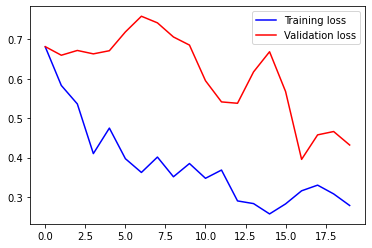

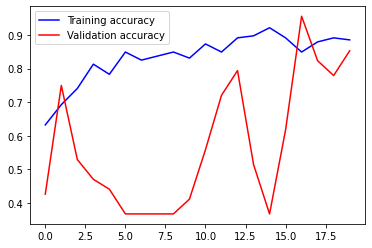

In [33]:
plot_results(resnet_rmsprop_static_history)

In [34]:
val_results(resnet_rmsprop_static)

Hockey Test Acc:  0.9 	Count:  90 
Movies Test Acc:  0.8 	Count:  4


In [35]:
fvideo , flabels = extract_frames_difference(traindf)

Video Processed 250/250

In [ ]:
tvideo , tlabels = extract_frames_difference(valdf)

In [ ]:
flabels = flabels.astype('float16')
#flabels = to_categorical(flabels ,num_classes=2)

tlabels = tlabels.astype('float16')
#tlabels = to_categorical(tlabels ,num_classes=2)

In [ ]:
print(fvideo.shape)
print(flabels.shape)

print(tvideo.shape)
print(tlabels.shape)

In [39]:
hockey_video , hockey_labels = extract_frames_difference(dtframe,300,400)

Video Processed 100/100

In [ ]:
movies_video , movies_labels = extract_frames_difference(dtframe2,189,199)

In [ ]:
print(hockey_video.shape)
print(hockey_labels.shape)

print(movies_video.shape)
print(movies_labels.shape)

In [ ]:
'''
  Defining the second model which uses the difference between frames to classify the action
'''
def CNN_CONVLSTM(model_arch, opt, retrain ,init_weights = 'imagenet'):

    input_shapes=(int(NUMBER_OF_FRAMES/2),IMAGE_SIZE,IMAGE_SIZE,3)

    if model_arch is 'Vgg19':
      base_model=VGG19(include_top=False,weights= init_weights ,input_shape=(IMAGE_SIZE, IMAGE_SIZE,3))
    elif model_arch is 'Resnet':
      base_model = ResNet50(include_top=False,weights=init_weights ,input_shape=(IMAGE_SIZE, IMAGE_SIZE,3))

    for layer in base_model.layers:
        layer.trainable = retrain

    cnn = TimeDistributed(base_model,  input_shape=input_shapes)
    
    model = Sequential()
    model.add(cnn)
    #model.add(TimeDistributed(Flatten()))

    
    model.add(ConvLSTM2D(filters=20, kernel_size=(3, 3),return_sequences=True))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation="sigmoid"))

    if opt is 'Adam':
      opti = Adam(lr=0.00001)
    elif opt is 'Sgd':
      opti = SGD(lr=0.00001)
    elif opt is 'RMSprop':
      opti = RMSprop(lr=0.00001)

    model.compile(loss='BinaryCrossentropy', optimizer= opti, metrics=["accuracy"])

    return model

In [ ]:
diff_vgg_rmsprop_retrain = CNN_CONVLSTM('Vgg19', 'RMSprop', True)
diff_vgg_rmsprop_retrain_history = diff_vgg_rmsprop_retrain.fit(fvideo,flabels, batch_size=10, epochs=20, validation_data=(tvideo , tlabels))

In [ ]:
diff_vgg_rmsprop_retrain.save("/drive/MyDrive/Colab\ Notebooks/model/ViolenceDetection.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
plot_results(diff_vgg_rmsprop_retrain_history)

In [ ]:
val_results(diff_vgg_rmsprop_retrain)

In [ ]:
diff_vgg_rmsprop_static = CNN_CONVLSTM('Vgg19', 'RMSprop', False)
diff_vgg_rmsprop_static_history = diff_vgg_rmsprop_static.fit(fvideo,flabels, batch_size=10, epochs=20, validation_data=(tvideo , tlabels))

In [ ]:
plot_results(diff_vgg_rmsprop_static_history)

In [ ]:
val_results(diff_vgg_rmsprop_static)

In [ ]:
diff_vgg_adam_retrain = CNN_CONVLSTM('Vgg19', 'Adam', True)
diff_vgg_adam_retrain_history = diff_vgg_adam_retrain.fit(fvideo,flabels, batch_size=10, epochs=20, validation_data=(tvideo , tlabels))

In [ ]:
plot_results(diff_vgg_adam_retrain_history)

In [ ]:
val_results(diff_vgg_adam_retrain)

In [ ]:
diff_resnet_rmsprop_retrain = CNN_CONVLSTM('Resnet', 'RMSprop', True)
diff_resnet_rmsprop_retrain_history = diff_resnet_rmsprop_retrain.fit(fvideo,flabels, batch_size=20, epochs=20, validation_data=(tvideo , tlabels))

In [ ]:
plot_results(diff_resnet_rmsprop_retrain_history)

In [ ]:
val_results(diff_resnet_rmsprop_retrain)